# Dependencies

In [ ]:
!pip install nltk
import nltk
nltk.download('all')
import kagglehub
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import time

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

In [ ]:
from nltk.tokenize import RegexpTokenizer, word_tokenize, sent_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

from collections import Counter
from wordcloud import WordCloud
from imblearn.over_sampling import RandomOverSampler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample

# Load Dataset

In [ ]:
kagglehub.dataset_download("amananandrai/ag-news-classification-dataset")
test_path = '/kaggle/input/ag-news-classification-dataset/test.csv'
train_path = '/kaggle/input/ag-news-classification-dataset/train.csv'

# EDA

EXPLORATORY TRAINING DATA ANALYSIS:

Training set shape: (120000, 3)
Number of unique classes: 4
Number of missing values: 
Class Index    0
Title          0
Description    0
dtype: int64

Class Distribution Count Plot:


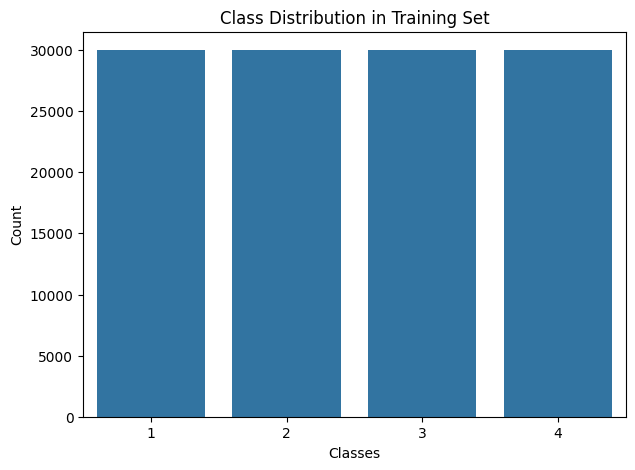


Average description length: 193.39 characters
Average title length: 42.07 characters

Wordcloud for Training Set after tokenization and stopword removal:


(np.float64(-0.5), np.float64(799.5), np.float64(399.5), np.float64(-0.5))

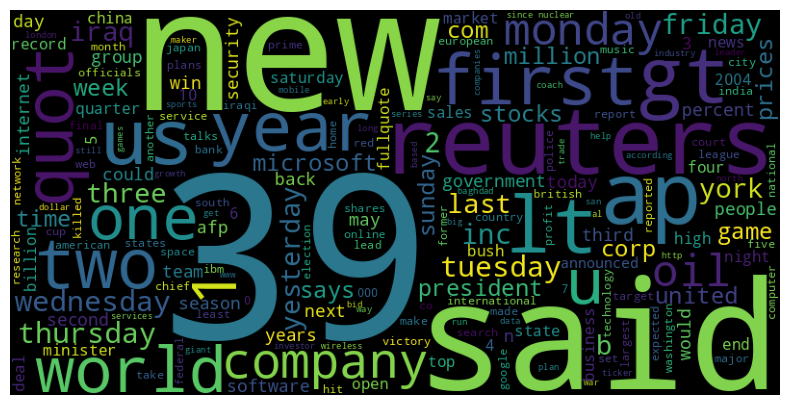

In [ ]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)


print("EXPLORATORY TRAINING DATA ANALYSIS:\n")
#print(df_train.head(5))
print(f"Training set shape: {df_train.shape}")
print(f"Number of unique classes: {df_train['Class Index'].nunique()}")
print(f"Number of missing values: \n{df_train.isna().sum()}")

print("\nClass Distribution Count Plot:")
plt.figure(figsize=(7, 5))
sns.countplot(data=df_train, x='Class Index')
plt.title('Class Distribution in Training Set')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

print(f"\nAverage description length: {df_train['Description'].str.len().mean():.2f} characters")
print(f"Average title length: {df_train['Title'].str.len().mean():.2f} characters")

#Word Frequency
combined_train = df_train['Title'] + ' ' + df_train['Description']
all_words = ' '.join(combined_train).lower()
tokenizer = RegexpTokenizer(r'\w+')           #exclude punctuations and stuff
tokens = tokenizer.tokenize(all_words)

filts = []
stoppers = set(stopwords.words('english'))
for i in tokens:
    if i not in stoppers:
        filts.append(i)

print("\nWordcloud for Training Set after tokenization and stopword removal:")
fdist = FreqDist(filts)
wc = WordCloud(width=800, height = 400, background_color='black').generate_from_frequencies(fdist)
plt.figure(figsize=(10,5))
plt.imshow(wc)
plt.axis('off')

# Pre-Processing

In [ ]:
#Tokenize and padding
combined_train = df_train['Title'] + ' ' + df_train['Description']
combined_test = df_test['Title'] + ' ' + df_test['Description']

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")  #vocabulary = 10000
tokenizer.fit_on_texts(combined_train)  #assigns integer to each word based on vocab

X_train_seq = tokenizer.texts_to_sequences(combined_train)  #text = word integer sequences
X_test_seq = tokenizer.texts_to_sequences(combined_test)
#print(X_train_seq[0])

X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_test_pad = pad_sequences(X_test_seq, maxlen=100)

y_train = df_train['Class Index'].values - 1  #Converts class labels from 1-4 to 0-3 for NN
y_test = df_test['Class Index'].values - 1

#Split training data
X_train_2, X_val, y_train_2, y_val = train_test_split(
   X_train_pad, y_train, test_size=0.2, random_state=42, stratify=y_train
)

class_counts = df_train['Class Index'].value_counts().sort_index()
min_count = class_counts.min()
max_count = class_counts.max()

if max_count / min_count > 1.1:  # If imbalance ratio exceeds 10%
   #Random Oversampling
   ros = RandomOverSampler(random_state=42)
   X_train_resampled, y_train_resampled = ros.fit_resample(X_train_2, y_train_2)
else:
   X_train_resampled, y_train_resampled = X_train_2, y_train_2

# Training

In [ ]:
#Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5,
                restore_best_weights=True) #Stop training if val_loss doesn't improve for 5 epochs


#BiLSTM Model
with tf.device('/GPU:0'):
    bilstm_model = Sequential([
        Embedding(10000, 128),     #128: Balance between complexity efficiency
        Bidirectional(LSTM(64, return_sequences=False)),  #false: only return final output/class_pred
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),                         #less dropout for ol
        Dense(4, activation='softmax')
    ])

    bilstm_model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',  #Multi-class classification loss
        metrics=['accuracy']
    )

    lstm_time = time.time()
    print("\nTraining BiLSTM Model...")
    bilstm_history = bilstm_model.fit(
        X_train_resampled, y_train_resampled,
        validation_data=(X_val, y_val),
        epochs=15,                    #15: Sufficient for convergence
        batch_size=64,                #64: Memory efficient
        callbacks=[early_stopping],
        verbose=1
    )
lstm_time = time.time() - lstm_time

#BiGRU Model
with tf.device('/GPU:0'):
    bigru_model = Sequential([
        Embedding(10000, 128),
        Bidirectional(GRU(64, return_sequences=False)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(4, activation='softmax')
    ])

    bigru_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )

    #Train BiGRU
    gru_time = time.time()
    print("\nTraining BiGRU Model...")
    bigru_history = bigru_model.fit(
        X_train_resampled, y_train_resampled,
        validation_data=(X_val, y_val),
        epochs=15,
        batch_size=64,
        callbacks=[early_stopping],
        verbose=1
    )
gru_time = time.time() - gru_time


Training BiLSTM Model...
Epoch 1/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.7741 - loss: 0.5840 - val_accuracy: 0.9141 - val_loss: 0.2727
Epoch 2/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - accuracy: 0.9253 - loss: 0.2485 - val_accuracy: 0.9173 - val_loss: 0.2602
Epoch 3/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9356 - loss: 0.2045 - val_accuracy: 0.9148 - val_loss: 0.2693
Epoch 4/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9462 - loss: 0.1646 - val_accuracy: 0.9154 - val_loss: 0.2901
Epoch 5/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9562 - loss: 0.1320 - val_accuracy: 0.9130 - val_loss: 0.2861
Epoch 6/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.9643 - loss: 0.1032 - val_accuracy: 0.9088 - val_loss: 0.3278
Epoch 7/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9726 - loss: 0.0798 - val_accuracy: 0.9116 - val_loss: 0.3407

Training BiGRU Model...
Epoch 1/15
1500/1500 ━━━━

# Evaluation

In [ ]:
#Predictions
bilstm_pred = bilstm_model.predict(X_test_pad)
bilstm_pred_classes = np.argmax(bilstm_pred, axis=1) #axis=1 operates along columns (across the classes)

bigru_pred = bigru_model.predict(X_test_pad)
bigru_pred_classes = np.argmax(bigru_pred, axis=1)

categories = ['World', 'Sports', 'Business', 'Sci/Tech']

#Classification Reports
print("\nBiLSTM Classification Report:")
print(classification_report(y_test, bilstm_pred_classes,
                         target_names=categories))

print("\nBiGRU Classification Report:")
print(classification_report(y_test, bigru_pred_classes,
                         target_names=categories))


#Confusion Matrix
cm_bilstm = confusion_matrix(y_test, bilstm_pred_classes)
print(f"\nConfusion Matrix for BiLSTM: \n{cm_bilstm}")

cm_bigru = confusion_matrix(y_test, bigru_pred_classes)
print(f"\nConfusion Matrix for BiGRU: \n{cm_bigru}")

#Accuracy
bilstm_accuracy = np.mean(bilstm_pred_classes == y_test)
bigru_accuracy = np.mean(bigru_pred_classes == y_test)

print(f"\nModel Performance Comparison:")
print(f"BiLSTM Test Accuracy: {bilstm_accuracy:.5f}")
print(f"BiGRU Test Accuracy: {bigru_accuracy:.5f}")
print(f"\nModel Training Times:")
print(f"BiLSTM: {lstm_time:.2f} seconds")
print(f"BiGRU: {gru_time:.2f} seconds")

#Analysis
print("\nModel Analysis:")
if bigru_accuracy > bilstm_accuracy:
   print("BiGRU outperformed BiLSTM.")
   print("GRU's simpler architecture with fewer parameters reduces overfitting risk.")
   print("GRU's reset and update gates provide efficient gradient flow for short sequences.")
else:
   print("BiLSTM outperformed BiLSTM.")
   print("LSTM's forget gate provides better long-term dependency modeling.")
   print("LSTM's separate cell state offers superior information retention.")

238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

BiLSTM Classification Report:
              precision    recall  f1-score   support

       World       0.92      0.89      0.91      1900
      Sports       0.95      0.98      0.96      1900
    Business       0.88      0.87      0.88      1900
    Sci/Tech       0.88      0.89      0.89      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600


BiGRU Classification Report:
              precision    recall  f1-score   support

       World       0.94      0.89      0.92      1900
      Sports       0.96      0.98      0.97      1900
    Business       0.89      0.86      0.88      1900
    Sci/Tech       0.86      0.92      0.89      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.9